# DSA simulations

In [13]:
% matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext line_profiler
%load_ext autoreload
%autoreload 2

from __future__ import division

import numpy as np
import glob, os
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.dpi'] = 2.5 * matplotlib.rcParams['figure.dpi']

import astropy
from astropy.time import Time

import enterprise
from enterprise.pulsar import Pulsar

import enterprise_extensions
from enterprise_extensions import models, model_utils

import libstempo as T2, libstempo.toasim as LT, libstempo.plot as LP
from ephem import Ecliptic, Equatorial

datadir = '../partim_no_noise/'

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
def figsize(scale):
    fig_width_pt = 513.17 #469.755                  # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0/72.27                       # Convert pt to inch
    golden_mean = (np.sqrt(5.0)-1.0)/2.0            # Aesthetic ratio (you could change this)
    fig_width = fig_width_pt*inches_per_pt*scale    # width in inches
    fig_height = fig_width*golden_mean              # height in inches
    fig_size = [fig_width,fig_height]
    return fig_size

#plt.rcParams.update(plt.rcParamsDefault)
params = {'backend': 'pdf',
        'axes.labelsize': 10,
        'lines.markersize': 4,
        'font.size': 10,
        'xtick.major.size':6,
        'xtick.minor.size':3,  
        'ytick.major.size':6,
        'ytick.minor.size':3, 
        'xtick.major.width':0.5,
        'ytick.major.width':0.5,
        'xtick.minor.width':0.5,
        'ytick.minor.width':0.5,
        'lines.markeredgewidth':1,
        'axes.linewidth':1.2,
        'legend.fontsize': 7,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'savefig.dpi':200,
        'path.simplify':True,
        'font.family': 'serif',
        'font.serif':'Times',
        'text.latex.preamble': [r'\usepackage{amsmath}',r'\usepackage{amsbsy}',
                                r'\DeclareMathAlphabet{\mathcal}{OMS}{cmsy}{m}{n}'],
        'text.usetex':True,
        'figure.figsize': figsize(0.5)}
plt.rcParams.update(params)

## Useful functions

In [15]:
import pandas as pd

In [16]:
# Get (equatorial) position of pulsars from name
def pos_from_name(name):
    pos = []
    for p in name:
        if '+' in p:
            tmp = p.split('+')
            raj = '{0}:{1}:00.00'.format(tmp[0][1:3],tmp[0][3:])
            decj = '+{0}:{1}:00.00'.format(tmp[1][:2],tmp[1][2:])
        else:
            tmp = p.split('-')
            raj = '{0}:{1}:00.00'.format(tmp[0][1:3],tmp[0][3:])
            decj = '-{0}:{1}:00.00'.format(tmp[1][:2],tmp[1][2:])

        eq = Equatorial(raj, decj)
        if 'B' in p: epoch = '1950'
        elif 'J' in p: epoch= '2000'
        ec = Ecliptic(eq, epoch=str(epoch))
        pos.append([float(eq.ra), float(eq.dec)])
    
    return np.array(pos)

# Get name of pulsar from (equatorial) position
def name_from_pos(pos):
    name = []
    for p in pos:
        eq = Equatorial(p[0], p[1])
        ra = str(eq.ra) 
        dec = str(eq.dec)
        #
        if float(ra.split(':')[0]) < 10:
            ra = '0' + ''.join(ra.split(':')[:2])
        else:
            ra = ''.join(ra.split(':')[:2])
        #
        if np.abs(float(dec.split(':')[0])) < 10:
            dec = ':'.join(['-0'+dec.split(':')[0][1:],dec.split(':')[1]])
        else:
            dec = ':'.join(dec.split(':')[:2])
        if float(dec.split(':')[0]) < 0:
            dec = ''.join(dec.split(':')[:2])
        elif float(dec.split(':')[0]) > 0:
            dec = '+' + ''.join(dec.split(':')[:2])
        else:
            dec = ''.join(dec.split(':')[:2])
        #
        name.append('J' + ra + dec)
    
    return np.array(name)

In [85]:
# Draw new random positions based on a sample
def invtran_sample(pos, size):
    x, y = pos[:,0], pos[:,1]                     
    hist, xbin, ybin = np.histogram2d(x, y, bins=(10, 10))
    xbinc = xbin[:-1] + np.diff(xbin)/2.0
    ybinc = ybin[:-1] + np.diff(ybin)/2.0
    cdf = np.cumsum(hist.ravel())
    cdf = cdf / cdf[-1]

    values = np.random.rand(size)
    value_bins = np.searchsorted(cdf, values)
    x_idx, y_idx = np.unravel_index(value_bins,
                                    (len(xbinc),
                                     len(ybinc)))
    delta_x = np.diff(xbin)[0]
    delta_y = np.diff(ybin)[0]
    if size == 1:
        random_from_cdf = [xbinc[x_idx][0] + np.random.uniform(-delta_x/2.0, delta_x/2.0),
                           ybinc[y_idx][0] + np.random.uniform(-delta_y/2.0, delta_y/2.0)]
    else:
        random_from_cdf = np.column_stack((xbinc[x_idx] + np.random.uniform(-delta_x/2.0, delta_x/2.0),
                                           ybinc[y_idx] + np.random.uniform(-delta_y/2.0, delta_y/2.0)))
    
    return random_from_cdf

In [86]:
def year2mjd(year):
    # rounds to nearest year
    return float(Time("{}-01-01T00:00:00".format(str(int(np.rint(year)))), 
                      format='isot').mjd)

def mjd2year(mjd):
    return float(Time(mjd, format='mjd').decimalyear)

## Process data

In [87]:
data = pd.read_csv('./RMSonlyvsTime2018-DSA2000.csv',header=0,skip_blank_lines=True)

In [88]:
# Correcting for mistake in spreadsheet
for ii,name in data.iterrows():
    if name.Observatory == 'GBT' and name.PSR == 'NEWPSR' and name.Epoch2 >= 2025:
        data.iloc[ii,6] = name.RMS3
        data.iloc[ii,7] = np.nan
        data.iloc[ii,8] = np.nan

In [89]:
# names of all real gbt and ao pulsars
real_pulsars_gbt = np.array([name.PSR for ii,name in data.iterrows() if 'NEWPSR' not in name.PSR and name.Observatory=='GBT'])
real_pulsars_ao = np.array([name.PSR for ii,name in data.iterrows() if 'NEWPSR' not in name.PSR and name.Observatory=='AO'])

# names of all fake gbt and ao pulsars (these are all NEWPSR)
fake_pulsars_gbt = np.array([name.PSR for ii,name in data.iterrows() if 'NEWPSR' in name.PSR and name.Observatory=='GBT'])
fake_pulsars_ao = np.array([name.PSR for ii,name in data.iterrows() if 'NEWPSR' in name.PSR and name.Observatory=='AO'])

In [90]:
# Get equatorial positions (ra, dec...in radians) from names
pos_pulsars_gbt = pos_from_name(real_pulsars_gbt)
pos_pulsars_ao = pos_from_name(real_pulsars_ao)

In [92]:
# Generate new fake pulsar positions
#fakepos_pulsars_gbt = invtran_sample(pos_pulsars_gbt, size=len(fake_pulsars_gbt))
#fakepos_pulsars_ao = invtran_sample(pos_pulsars_ao, size=len(fake_pulsars_ao))
fakepos_pulsars_gbt = np.array([invtran_sample(pos_pulsars_gbt, size=1) for ii in range(len(fake_pulsars_gbt))])
fakepos_pulsars_ao = np.array([invtran_sample(pos_pulsars_ao, size=1) for ii in range(len(fake_pulsars_ao))])

# Generate new fake pulsar names
fake_pulsars_gbt = name_from_pos(fakepos_pulsars_gbt)
fake_pulsars_ao = name_from_pos(fakepos_pulsars_ao)

In [96]:
# Make copy of data frame and replace NEWPSR with new names

data_copy = data.copy(deep=True)
ct_gbt = 0
ct_ao = 0
for ii,name in data_copy.iterrows():
    
    # New GBT pulsars
    if name.Observatory == 'GBT' and name.PSR=='NEWPSR':
        #tmp_pos = invtran_sample(pos_pulsars_gbt, size=1)
        #tmp_name = name_from_pos(tmp_pos)
        #data_copy.iloc[ii,0] = tmp_name[0]
        data_copy.iloc[ii,0] = fake_pulsars_gbt[ct_gbt]
        ct_gbt += 1
        
    # New AO pulsars
    if name.Observatory == 'AO' and name.PSR=='NEWPSR':
        #tmp_pos = invtran_sample(pos_pulsars_ao, size=1)
        #tmp_name = name_from_pos(tmp_pos)
        #data_copy.iloc[ii,0] = tmp_name[0]
        data_copy.iloc[ii,0] = fake_pulsars_ao[ct_ao]
        ct_ao += 1

In [97]:
# Create new data columns for RAJ and DECJ

data_copy = data_copy.assign(RAJ=pd.Series(np.concatenate([pos_pulsars_gbt[:,0],
                                                           fakepos_pulsars_gbt[:,0],
                                                           pos_pulsars_ao[:,0],
                                                           fakepos_pulsars_ao[:,0]])).values)

data_copy = data_copy.assign(DECJ=pd.Series(np.concatenate([pos_pulsars_gbt[:,1],
                                                           fakepos_pulsars_gbt[:,1],
                                                           pos_pulsars_ao[:,1],
                                                           fakepos_pulsars_ao[:,1]])).values)

In [98]:
# Write to csv
data_copy.to_csv('./data_copy.csv')

In [7]:
# Read from csv
data_copy = pd.read_csv('./data_copy.csv')

## Creating par files

In [99]:
for ii,name in data_copy.iterrows():
    
    # Get coordinates for par file
    tmp = Equatorial(data_copy.iloc[ii].RAJ, data_copy.iloc[ii].DECJ, epoch='2000')
    
    # Set PEPOCHs to be 5 years in
    if np.isnan(name.RMS1):
        start = name.Epoch2
    else:
        start = name.Epoch1
    
    with open('./template.par', 'r') as fil:
        pardata = fil.read()
        
    with open('./partim/' + name.PSR + '.par', 'w') as filnew:
        for line in pardata.split('\n'):
            if 'PSR' in line:
                print >>filnew, '\t\t'.join([line.split()[0], name.PSR])
            elif 'RAJ' in line:
                print >>filnew, '\t\t'.join([line.split()[0], str(tmp.ra), 
                                         line.split()[2], line.split()[3]])
            elif 'DECJ' in line:
                print >>filnew, '\t\t'.join([line.split()[0], str(tmp.dec), 
                                         line.split()[2], line.split()[3]])
            elif 'PEPOCH' in line or 'POSEPOCH' in line or 'DMEPOCH' in line:
                print >>filnew, '\t\t'.join([line.split()[0], str(int(year2mjd(start+5)))])
            else:
                print >>filnew, line
    print name.PSR

J0340+4130
J0605+3757
J0610-2100
J0613-0200
J0636+5128
J0645+5158
J0740+6620
J0931-1902
J1012+5307
J1012-4235
J1024-0719
J1125+7819
J1455-3330
J1600-3053
J1614-2230
J1630+3734
J1643-1224
J1705-1903
J1719-1438
J1730-2304
J1744-1134
J1747-4036
J1751-2857
J1802-2124
J1811-2405
J1832-0836
J1843-1113
J1909-3744
J1911-1114
J1918-0642
J2010-1323
J2124-3358
J2145-0750
J2302+4442
J2245+4231
J1805-2725
J1552-2842
J1557-1339
J0623-0427
J2106-4048
J1750-2322
J0536+5241
J1418-3408
J1805-0833
J1605-3403
J0552+5027
J1907-2309
J1738-2814
J1730-2800
J0648+4710
J0635-2920
J1843-1336
J1528+3105
J2146-3918
J1053-0730
J1718-1925
J0950-3107
J1527-2746
J1624+3906
J1741-1725
J1151+6712
J1015-1142
J1900-2735
J1850-2803
J1329-3840
J2140-1436
J1738-0949
J2118+4636
J1053-1733
J1822-1331
J1028-3143
J1424-4106
J1729-0836
J0548+4145
J2206-1126
J1629-2636
J1850-4123
J1815-3915
J0023+0923
J0030+0451
J0337+1715
J0406+3039
J0509+0856
J0557+1551
J0621+2514
J0709+0458
J1022+1001
B1257+12
J1312+0051
J1453+1902
J1640+2224
J

## Creating tim files

In [100]:
dsa_sims = []
start_data = []
for jj,name in data_copy.iterrows():
    
    psrname = name.PSR
    
    ### Start and End year
    if np.isnan(name.RMS1):
        start_yr = name.Epoch2
    else:
        start_yr = name.Epoch1
    start_yr_mjd = year2mjd(start_yr)
    #
    end_yr = 2045
    end_yr_mjd = year2mjd(end_yr)
    
    ### Spacing and obstimes
    spacing = 365.25 / 20.0 # days between observations
    #
    obstimes = np.arange(start_yr_mjd, end_yr_mjd, spacing)
    
    ### Segmenting obstimes based on hardware/telescope switches
    stops = []
    errors = []
    if np.isnan(name.RMS1):
        stops.append(year2mjd(name.Epoch2))
        errors.append(name.RMS2)
    else:
        stops.append(year2mjd(name.Epoch1))
        stops.append(year2mjd(name.Epoch2))
        errors.append(name.RMS1)
        errors.append(name.RMS2)
    #
    if np.isnan(name.RMS3):
        stops.append(end_yr_mjd)
    else:
        stops.append(year2mjd(name.Epoch3))
        errors.append(name.RMS3)
        if np.isnan(name.RMS4):
            stops.append(end_yr_mjd)
        else:
            stops.append(year2mjd(name.Epoch4))
            errors.append(name.RMS4)
            if np.isnan(name.RMS5):
                stops.append(end_yr_mjd)
            else:
                stops.append(year2mjd(name.Epoch5))
                stops.append(end_yr_mjd)
                errors.append(name.RMS5)
    
    ### Masking sections of data based on these stops
    masks = []
    for kk,stop in enumerate(stops):
        if kk < len(stops)-1:
            masks.append(np.logical_and(obstimes >= stops[kk], 
                                        obstimes <= stops[kk+1]))
    
    ### Applying RMS errors
    toa_errs = np.ones_like(obstimes)
    for kk,mask in enumerate(masks):
        toa_errs[mask] *= float(errors[kk])
    
    ### Make fake dataset
    par = './partim/' + psrname + '.par'
    dsa_sims.append(LT.fakepulsar(par, obstimes, toa_errs))
    # white noise
    LT.add_efac(dsa_sims[jj])
    # save .tim
    dsa_sims[jj].savetim('./partim/' + dsa_sims[jj].name + '.tim')
    ###
    
    start_data.append([psrname, start_yr, start_yr_mjd])
    print psrname, par, start_yr_mjd, end_yr_mjd, len(stops), len(masks), len(errors)

J0340+4130 ./partim/J0340+4130.par 55927.0 67981.0 4 3 3
J0605+3757 ./partim/J0605+3757.par 57754.0 67981.0 4 3 3
J0610-2100 ./partim/J0610-2100.par 57754.0 67981.0 4 3 3
J0613-0200 ./partim/J0613-0200.par 53371.0 67981.0 5 4 4
J0636+5128 ./partim/J0636+5128.par 56658.0 67981.0 4 3 3
J0645+5158 ./partim/J0645+5158.par 55562.0 67981.0 4 3 3
J0740+6620 ./partim/J0740+6620.par 56658.0 67981.0 4 3 3
J0931-1902 ./partim/J0931-1902.par 56293.0 67981.0 4 3 3
J1012+5307 ./partim/J1012+5307.par 53371.0 67981.0 5 4 4
J1012-4235 ./partim/J1012-4235.par 57754.0 67981.0 4 3 3
J1024-0719 ./partim/J1024-0719.par 55197.0 67981.0 4 3 3
J1125+7819 ./partim/J1125+7819.par 56658.0 67981.0 4 3 3
J1455-3330 ./partim/J1455-3330.par 53371.0 67981.0 5 4 4
J1600-3053 ./partim/J1600-3053.par 54466.0 67981.0 5 4 4
J1614-2230 ./partim/J1614-2230.par 54832.0 67981.0 5 4 4
J1630+3734 ./partim/J1630+3734.par 57754.0 67981.0 4 3 3
J1643-1224 ./partim/J1643-1224.par 53371.0 67981.0 5 4 4
J1705-1903 ./partim/J1705-1903.

In [101]:
start_data = np.array(start_data)
start_data[start_data[:,1].argsort()]

fil = open('sims_psr_startdata.txt','w')
for line in start_data[start_data[:,1].argsort()]:
    print >>fil, line[0], line[1], line[2]
fil.close()

# Read In And Check Pulsars

In [102]:
import enterprise
from enterprise.pulsar import Pulsar
from enterprise.signals import parameter
from enterprise.signals import white_signals
from enterprise.signals import gp_signals
from enterprise.signals import signal_base

import enterprise_extensions
from enterprise_extensions import models, model_utils

In [103]:
psr = Pulsar('./partim/J0613-0200.par', './partim/J0613-0200.tim', ephem='DE436')

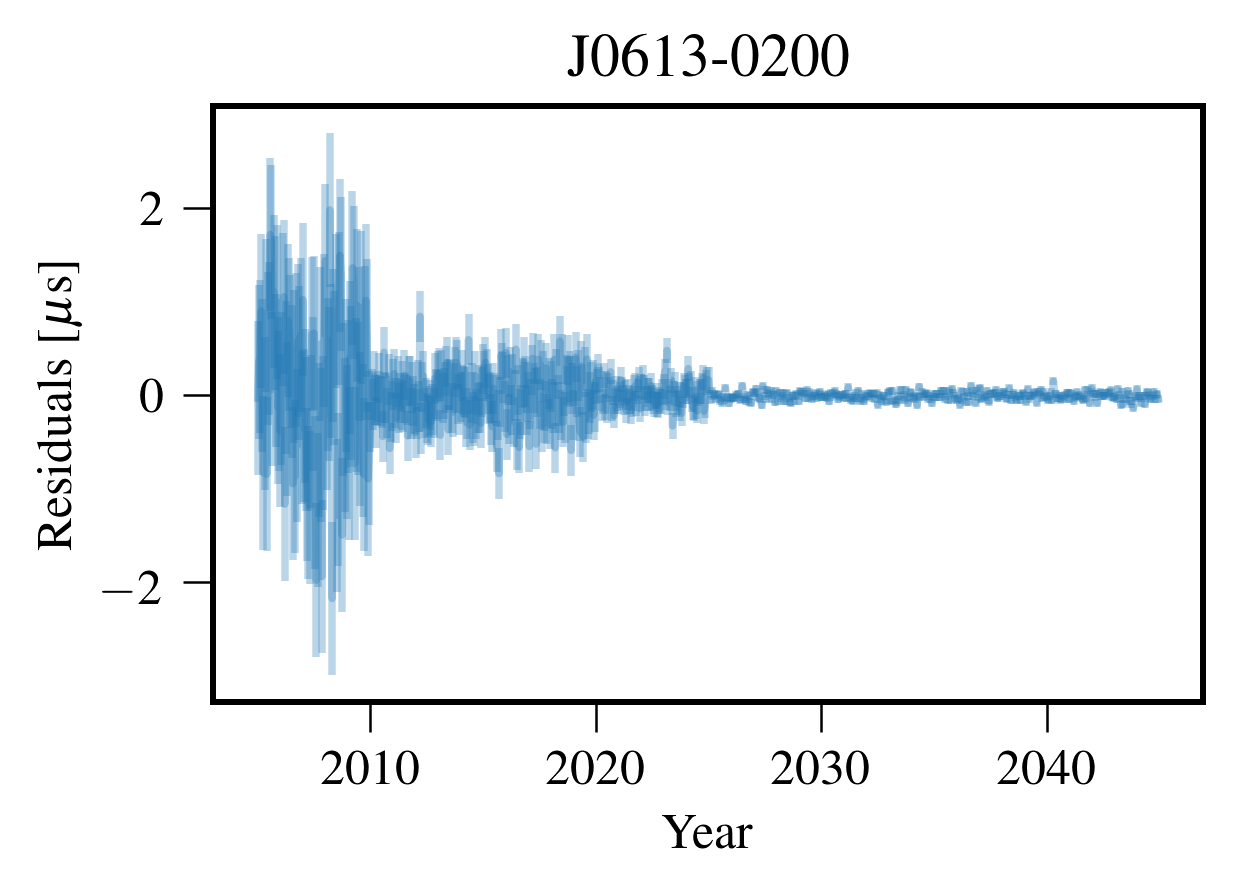

In [104]:
plt.errorbar([mjd2year(p) for p in psr.toas/86400.0], psr.residuals/1e-6, psr.toaerrs/1e-6, alpha=0.3)
plt.xlabel(r'Year')
plt.ylabel(r'Residuals [$\mu$s]')
plt.title(psr.name)